# Coding

In [3]:
import numpy as np
import torch
import pandas as pd
from tqdm.auto import tqdm
import pickle
import copy
import sys
from os import path
import matplotlib.pyplot as plt
from factor_analyzer import FactorAnalyzer, Rotator
from sloth import *
from definitions import *

device = 'cpu'
d=2 #Sloth dimensions

In [512]:
data = pd.read_csv('data/data_v2.csv')
data['logS'] = np.log10(data['#Params (B)'])
data['logT'] = np.log10(data['Pretraining Data Size (T)'])
data['logSlogT'] = data['logS']*data['logT']
#data['logS2'] = data['logS']**2
#data['logT2'] = data['logT']**2
data['GreatFamily'] = data['Family']
data['Family'] = data['Family2']
X_names = ['logS','logT','logSlogT'] 
Y_agentic = ['MMLU', 'HellaSwag', 'HellaSwag', 'Winogrande', 'IFEval']
Y_names = ['GSM8K',
           'MATH Lvl 5',
           'GPQA',
           'MMLU',
           'MMLU-PRO',
           'BBH',
           'MUSR',
           'TruthfulQA',
           'ARC',
           'HellaSwag',
           'Winogrande',
           'IFEval']
Y_OOD = ['HumanEval']
data_sloth = data.loc[:,['Model','Family','GreatFamily','Instruct']+X_names+Y_names].dropna()
holdout_names = ['meta-llama-3-70b-instruct', 'meta-llama-3-70b']
data_hold = data.loc[data['Model'].isin(holdout_names)]
Models_dict = {k: v for v, k in enumerate(list(data_sloth['Model']))}
to_drop = []
for model in holdout_names:
    to_drop.append(Models_dict[model])
to_drop.sort()
#for name in holdout_names:
    #data_sloth = data_sloth[data.Model != name]
#data_tr = data.loc[:,['Model','Family','GreatFamily','Instruct']+X_names+Y_names]
data_OOD = data.loc[:,['Model','Family','GreatFamily','Instruct']+X_names+Y_names+['HumanEval']].dropna()
for name in holdout_names:
    data_OOD = data_OOD[data.Model != name]

/tmp/ipykernel_29340/2711878370.py:37: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_OOD = data_OOD[data.Model != name]


In [513]:
D_whole = np.array(pd.get_dummies(np.array(data_sloth.Family))).astype(float)
D = np.delete(D_whole, to_drop, axis=0)
#D = np.ones(38)[np.newaxis, :].T
X_whole = np.array(data_sloth.loc[:,X_names]).astype(float)
X = np.delete(X_whole, to_drop, axis=0)
Y_whole = np.array(data_sloth.loc[:,Y_names]).astype(float)
Y = np.delete(Y_whole, to_drop, axis=0)
Cs = []
for s in Y_names:
    Cs.append(lower_bounds[s])
Cs = np.array(Cs).astype(float)[None,:]
Y.shape

(77, 12)

In [514]:
model = Sloth(d=3)
model.fit(X, D, Y, Cs, fit_C=False, train_link=False, positive_w=False, verbose=True)
model.best_loss

  0%|          | 0/100000 [00:00<?, ?it/s]

0.1 0.024269765242934227


  0%|          | 0/100000 [00:00<?, ?it/s]

0.01 0.02427876926958561


  0%|          | 0/100000 [00:00<?, ?it/s]

0.001 0.024296997115015984


0.024269765242934227

In [515]:
d= 3
if d==1:
    L_rot=-model.W2.numpy()
    B_rot=-np.vstack((model.W1_X.detach().numpy(), model.W1_D.detach().numpy()))
    Z = np.hstack((X,D))@B_rot
else:
    Z = model.interpret(anchor=0)['skills']
    L_rot = model.interpret(anchor=0)['loadings']
    B_rot = model.interpret(anchor=0)['B']
    Delta = model.interpret(anchor=0)['translation']

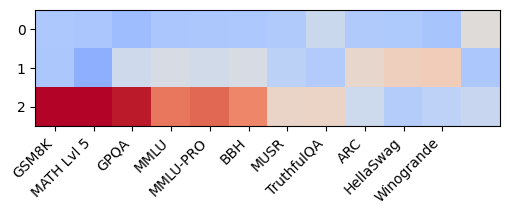

In [516]:
colormap = "coolwarm"
vmin=-1
vmax=2
plt.figure(figsize=(6, 3))  # Set the figure size (width, height) in inches
plt.imshow(L_rot, cmap=colormap, vmin=vmin, vmax=vmax)
plt.xticks(np.arange(len(Y_names)-1), labels=Y_names[0:len(Y_names)-1], rotation=45, ha="right")  # Set the x-tick labels
plt.yticks(np.arange(d), rotation=0, ha="right")  # Set the y-tick labels
plt.show()

In [517]:
for name in holdout_names:
    data_sloth = data_sloth[data.Model != name]
Skills_dict = {k: v for v, k in enumerate(list(data_sloth['Model']))}
to_keep = []
for model in list(data_OOD['Model']):
    to_keep.append(Skills_dict[model])
X_tr = Z[to_keep]
Inter_train  = np.ones(X_tr.shape[0])[np.newaxis, :].T
Y_tr = np.array(data_OOD.loc[:,'HumanEval']).astype(float)
Y_tr = Y_tr[np.newaxis, :].T
Y_tr.shape

/tmp/ipykernel_29340/2044406671.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_sloth = data_sloth[data.Model != name]


(40, 1)

In [518]:
D_hold = D_whole[to_drop]
#D_hold = D[to_drop]
X_hold = X_whole[to_drop]
Y_hold = np.array(data_hold.loc[:,'HumanEval']).astype(float)
Y_hold = Y_hold[np.newaxis, :].T
Y_hold.shape

(2, 1)

In [519]:
model_ood = Sloth(d=1) 
model_ood.fit(X_tr, Inter_train, Y_tr,
                                      C0=np.array([[0]]),
                                      train_link=False, fit_C=False, positive_w=False, verbose=False)

In [520]:
Z_hold = np.hstack((X_hold,D_hold))@B_rot-Delta

In [521]:
B_ood=np.vstack((model_ood.W1_X.detach().numpy(), model_ood.W1_D.detach().numpy()))

In [522]:
B_ood

array([[ 0.13872446],
       [-0.01543578],
       [ 0.8452422 ],
       [-0.10784606]], dtype=float32)

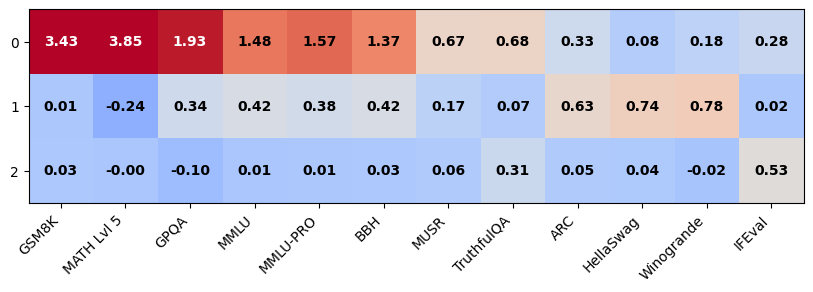

In [476]:
vmin=-1
vmax=2
#factor_labels = ['Instruction Following, Knowledge, Reasoning']
plt.figure(figsize=(10, 6))  # Set the figure size (width, height) in inches
plt.imshow(L_rot, cmap=colormap, vmin=vmin, vmax=vmax)
plt.xticks(np.arange(len(Y_names)), labels=Y_names, rotation=45, ha="right")  # Set the x-tick labels
plt.yticks(np.arange(d), rotation=0, ha="right")
L_rot = L_rot[::-1]
#Lperm = L_rot.copy()
#Lperm[[0,1,2]] = L_rot[[0, 2,1]]
#Lperm[1] = -1*Lperm[1]
#Lperm = Lperm[::-1]
# map 0 -> 4 and 1 -> 3 (N.B. Python indexing starts at 0 rather than 1)
inter = [-.3,1.6]
for i in range(len(L_rot)):
    for j in range(len(L_rot.T)):
        value = L_rot[::-1][i, j]
        color = "black" if value > inter[0] and  value < inter[1] else "white"  # Conditional color
        text = plt.text(j, i, f'{value:.2f}', size=10, ha="center", va="center", color=color, weight='bold')#
plt.savefig('Lambda.pdf', bbox_inches='tight')
plt.show()

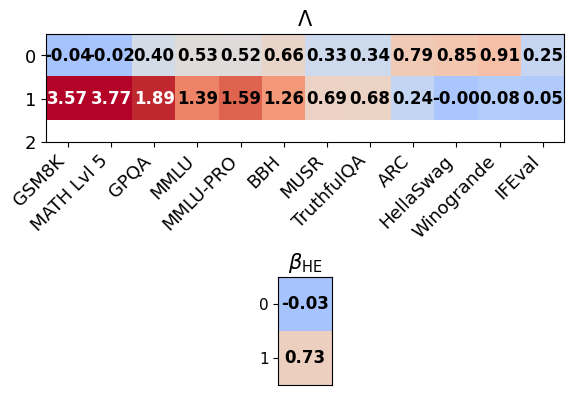

In [321]:
colormap = "coolwarm"
vmin=-1
vmax=2
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,4))
 # Set the figure size (width, height) in inches
#ax1.set_figwidth(6)
#ax1.set_figheight(3)
ax1.imshow(L_rot, cmap=colormap, vmin=vmin, vmax=vmax)
inter = [-.3,1.6]
for i in range(len(L_rot)):
    for j in range(len(L_rot.T)):
        value = L_rot[i, j]
        color = "black" if value > inter[0] and  value < inter[1] else "white"  # Conditional color
        text = ax1.text(j, i, f'{value:.2f}', size=12, ha="center", va="center", color=color, weight='bold')#
ax1.set_xticks(np.arange(len(Y_names)), labels=Y_names, rotation=45, ha="right")  # Set the x-tick labels
ax1.set_yticks(np.arange(d))
ax1.tick_params(labelsize=13) 
# Set the y-tick labels
ax1.set_title('$\\Lambda$', size=15)
#plt.subplot(1, 2, 2)  # Set the figure size (width, height) in inches
#ax2.set_figwidth(3)
#ax2.set_figheight(1)
ax2.imshow(B_ood[0:2], cmap=colormap, vmin=vmin, vmax=vmax)
inter = [-.3,1.6]
for i in range(len(B_ood[0:2])):
    for j in range(len(B_ood.T)):
        value = B_ood[i, j]
        color = "black" if value > inter[0] and  value < inter[1] else "white"  # Conditional color
        text = ax2.text(j, i, f'{value:.2f}', size=12, ha="center", va="center", color=color, weight='bold')#
ax2.set_xticks([],[])  # Set the x-tick labels
ax2.set_yticks(np.arange(2))  # Set the y-tick labels
ax2.tick_params(labelsize=11) 
ax2.set_title('$\\beta_{\\text{HE}}$', size = 15)
plt.tight_layout()
plt.savefig('HE_Parameters.pdf', bbox_inches='tight')
plt.show()

In [523]:
x, y = np.concatenate((X_tr, Inter_train), axis = 1) @ B_ood, Y_tr
x_test, y_test = np.concatenate((Z_hold, np.ones(2)[np.newaxis, :].T), axis = 1) @ B_ood, Y_hold
a, b, c, e = np.linspace(-5, 5, 100), np.linspace(-5, 5, 100), np.linspace(-5, 2, 100), np.linspace(-5, 2, 100)
Grid = np.vstack((a.flatten(), b.flatten(), c.flatten())).T
y_curve = model_ood.predict(Grid, np.array([[1]]))

In [524]:
x_grid = np.concatenate((Grid, np.ones(100)[np.newaxis, :].T), axis = 1) @ B_ood

In [530]:
y_test[1]

array([0.774])

In [532]:
x_test[1]

array([1.43399276])

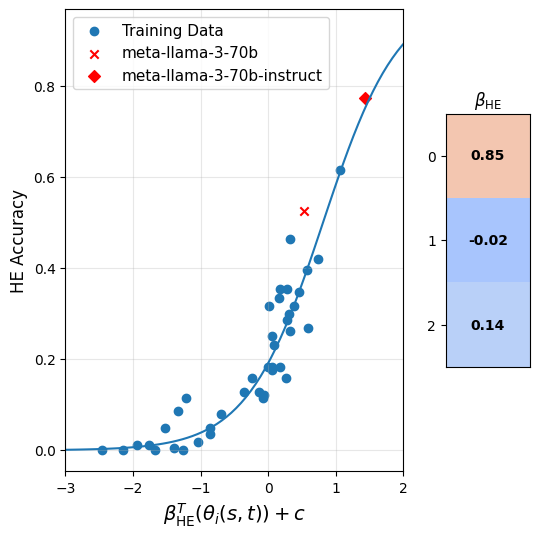

In [539]:
colormap = "coolwarm"
vmin=-1
vmax=2
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6,6), width_ratios=[4, 1])
 # Set the figure size (width, height) in inches
#ax1.set_figwidth(6)
#ax1.set_figheight(3)
Bperm = B_ood.copy()
#Bperm[[0,1,2]] = Bperm[[0, 2,1]]
ax2.imshow(Bperm[0:3][::-1], cmap=colormap, vmin=vmin, vmax=vmax)
inter = [-.3,1.6]
for i in range(len(B_ood[0:3])):
    for j in range(len(B_ood[0:3].T)):
        value = Bperm[0:3][::-1][i, j]
        color = "black" if value > inter[0] and  value < inter[1] else "white"  # Conditional color
        text = ax2.text(j, i, f'{value:.2f}', size=10, ha="center", va="center", color=color, weight='bold')#
ax2.set_xticks([], [])  # Set the x-tick labels
ax2.set_yticks(np.arange(d))  # Set the y-tick labels
ax2.set_title('$\\beta_{\\text{HE}}$', size = 12)
#ax2.tick_params(labelsize=11)
ax1.scatter(x,y, label = 'Training Data')
ax1.scatter(x_test[0],y_test[0], color = 'red', label = 'meta-llama-3-70b', marker = 'x')
ax1.scatter(x_test[1],y_test[1], color = 'red', label = 'meta-llama-3-70b-instruct', marker = 'D')
ax1.set_xlim(-3, 2)
#ax2.ylim(0,1)
ax1.set_xlabel('$\\beta_{\\text{HE}}^T(\\theta_{i}(s,t)) +c$', size = 14)
ax1.grid(alpha = 0.3)
ax1.plot(x_grid, y_curve)
ax1.set_ylabel('HE Accuracy', size = 12)
#ax2.tick_params(labelsize=11)
ax1.legend(prop={'size':11}, loc = 'upper left')
plt.savefig('HE_Plot.pdf', bbox_inches='tight')
plt.show()

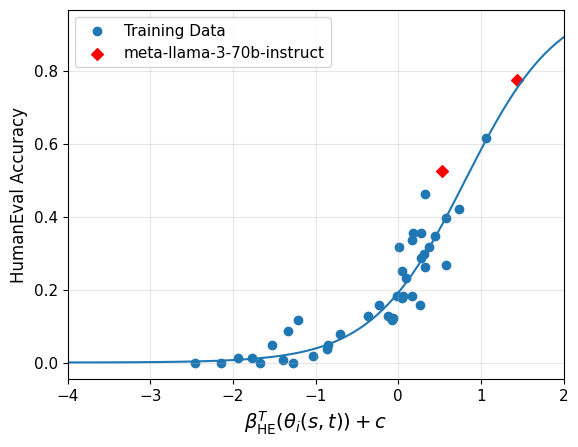

In [431]:
plt.scatter(x,y, label = 'Training Data')
markers = ['D']
for i in range(len(markers)):
    plt.scatter(x_test,y_test, color = 'red', marker = markers[i], label = holdout_names[i])
plt.xlim(-4, 2)
plt.xlabel('$\\beta_{\\text{HE}}^T(\\theta_{i}(s,t)) +c$', size = 14)
plt.grid(alpha = 0.3)
plt.plot(x_grid, y_curve)
plt.ylabel('HumanEval Accuracy', size = 12)
plt.tick_params(labelsize=11)
plt.legend(prop={'size':11})
plt.savefig('HE_Predictions.pdf', bbox_inches='tight')
plt.show()

# Agentic AI

In [23]:
data = pd.read_csv('data/Agent.csv')
data['logS'] = np.log10(data['Model Size (B)'])
data['logT'] = np.log10(data['Pretraining Data Size (T)'])
data['logSlogT'] = data['logS']*data['logT']
data['logS2'] = data['logS']**2
data['logT2'] = data['logT']**2
data['ModelFamily'] = data['Model Family']
#data['Family'] = data['Family2']
#X_names = ['logS','logT', 'logSlogT'] 
#X_names = ['logS','logT']
X_names = ['logS','logT', 'logSlogT', 'logS2', 'logT2']
Y_agentic = ['ABench-OA', 'ABoard-Avg_SR']
S_base = ['MMLU', 'ARC-C', 'HellaSwag']
S_extra = ['GSM8K',
           'TruthfulQA',
           'Winogrande', 'HumanEval']
data_agentic = data.loc[:,['Model', 'ModelFamily']+X_names+S_base+S_extra+[Y_agentic[0]]].dropna()
holdout_names = ['llama-2-70b-chat']
data_hold = data.loc[data['Model'].isin(holdout_names)]
Models_dict = {k: v for v, k in enumerate(list(data_agentic['Model']))}
to_drop = []
for model in holdout_names:
    to_drop.append(Models_dict[model])
to_drop.sort()
data_OOD = data_agentic.loc[:,['Model','ModelFamily']+X_names+[Y_agentic[0]]].dropna()
for name in holdout_names:
    data_OOD = data_OOD[data.Model != name]

/tmp/ipykernel_28949/799112695.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_OOD = data_OOD[data.Model != name]


In [24]:
#D_whole = np.array(pd.get_dummies(np.array(data_agentic.ModelFamily))).astype(float)
#D = np.delete(D_whole, to_drop, axis = 0)
D = np.ones(14)[np.newaxis, :].T
X_whole = np.array(data_agentic.loc[:,X_names]).astype(float)
X = np.delete(X_whole, to_drop, axis=0)
S_whole = np.array(data_agentic.loc[:,S_base+S_extra]).astype(float)
S = np.delete(S_whole, to_drop, axis=0)
Cs = []
for s in S_base+S_extra:
    if s!= 'ARC-C' and s!='HumanEval':
        Cs.append(lower_bounds[s])
    else:
        if s == 'HumanEval':
            Cs.append(0)
        else:
            Cs.append(0.36)
Cs = np.array(Cs).astype(float)[None,:]

In [25]:
d=2
model = Sloth(d=d)
model.fit(X, D, S, Cs, fit_C=False, train_link=False, positive_w=False, verbose=True)
model.best_loss

  0%|          | 0/100000 [00:00<?, ?it/s]

0.1 0.024963272735476494


  0%|          | 0/100000 [00:00<?, ?it/s]

0.01 0.02500941790640354


  0%|          | 0/100000 [00:00<?, ?it/s]

0.001 0.025042833760380745


0.024963272735476494

In [26]:
d= d
if d==1:
    L_rot=-model.W2.numpy()
    B_rot=-np.vstack((model.W1_X.detach().numpy(), model.W1_D.detach().numpy()))
    Z = np.hstack((X,D))@B_rot
else:
    Z = model.interpret(anchor=0)['skills']
    L_rot = model.interpret(anchor=0)['loadings']
    B_rot = model.interpret(anchor=0)['B']
    Delta = model.interpret(anchor=0)['translation']

In [34]:
for name in holdout_names:
    data_agentic = data_agentic[data.Model != name]
Skills_dict = {k: v for v, k in enumerate(list(data_agentic['Model']))}
to_keep = []
for model in list(data_OOD['Model']):
    to_keep.append(Skills_dict[model])
X_tr = Z[to_keep]
Inter_train  = np.ones(X_tr.shape[0])[np.newaxis, :].T
Y_tr = np.array(data_OOD.loc[:,Y_agentic[0]]).astype(float)
Y_tr = Y_tr[np.newaxis, :].T/10
Y_tr.shape

/tmp/ipykernel_28949/1040522258.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_agentic = data_agentic[data.Model != name]


(14, 1)

In [35]:
model_ood = Sloth(d=1) 
model_ood.fit(X_tr, Inter_train, Y_tr,
                                      C0=np.array([[0]]),
                                      train_link=False, fit_C=True, positive_w=False, verbose=False)

In [42]:
D_hold = D[to_drop]
X_hold = X_whole[to_drop]
Y_hold = np.array(data_hold.loc[:,Y_agentic[0]]).astype(float)
Y_hold = Y_hold[np.newaxis, :].T/10
Y_hold.shape

(1, 1)

In [37]:
Z_hold = np.hstack((X_hold,D_hold))@B_rot-Delta
B_ood=np.vstack((model_ood.W1_X.detach().numpy(), model_ood.W1_D.detach().numpy()))

In [38]:
B_ood

array([[ 1.0829092],
       [-0.282188 ],
       [-1.5124513]], dtype=float32)

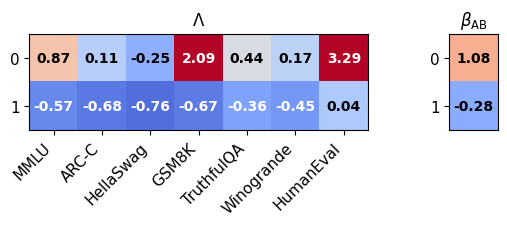

In [39]:
colormap = "coolwarm"
vmin=-1
vmax=2
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6,2), width_ratios=[2, 1])
 # Set the figure size (width, height) in inches
#ax1.set_figwidth(6)
#ax1.set_figheight(3)
ax1.imshow(L_rot, cmap=colormap, vmin=vmin, vmax=vmax)
inter = [-.3,1.6]
for i in range(len(L_rot)):
    for j in range(len(L_rot.T)):
        value = L_rot[i, j]
        color = "black" if value > inter[0] and  value < inter[1] else "white"  # Conditional color
        text = ax1.text(j, i, f'{value:.2f}', size=10, ha="center", va="center", color=color, weight='bold')#
ax1.set_xticks(np.arange(len(S_base+S_extra)), labels=S_base+S_extra, rotation=45, ha="right")  # Set the x-tick labels
ax1.set_yticks(np.arange(d))  # Set the y-tick labels
ax1.set_title('$\\Lambda$', size = 12)
ax1.tick_params(labelsize=11)
#plt.subplot(1, 2, 2)  # Set the figure size (width, height) in inches
#ax2.set_figwidth(3)
#ax2.set_figheight(1)
ax2.imshow(B_ood[0:d], cmap=colormap, vmin=vmin, vmax=vmax)
inter = [-.3,1.6]
for i in range(len(B_ood[0:d])):
    for j in range(len(B_ood.T)):
        value = B_ood[i, j]
        color = "black" if value > inter[0] and  value < inter[1] else "white"  # Conditional color
        text = ax2.text(j, i, f'{value:.2f}', size=10, ha="center", va="center", color=color, weight='bold')#
ax2.set_xticks([],[])  # Set the x-tick labels
ax2.set_yticks(np.arange(d))  # Set the y-tick labels
ax2.set_title('$\\beta_{\\text{AB}}$', size = 12)
ax2.tick_params(labelsize=11)
plt.tight_layout()
#plt.savefig('AB_Parameters.pdf', bbox_inches='tight')
plt.show()

In [44]:
x, y = np.concatenate((X_tr, Inter_train), axis = 1) @ B_ood, Y_tr
x_test, y_test = np.concatenate((Z_hold, np.ones(1)[np.newaxis, :].T), axis = 1) @ B_ood, Y_hold
a, b, c, e = np.linspace(-10, 10, 100), np.linspace(-10, 10, 100), np.linspace(-10, 10, 100), np.linspace(-2, 5, 100)
Grid = np.vstack((a.flatten(), b.flatten())).T
y_curve = model_ood.predict(Grid, np.array([[1]]))
x_grid = np.concatenate((Grid, np.ones(100)[np.newaxis, :].T), axis = 1) @ B_ood

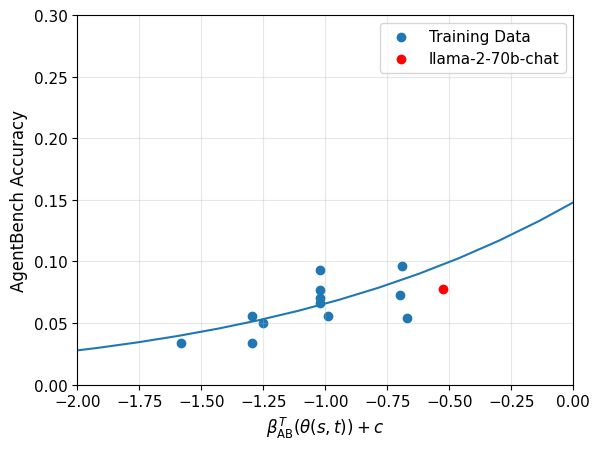

In [49]:
plt.scatter(x,y, label = 'Training Data')
plt.scatter(x_test,y_test, color = 'red', label = 'llama-2-70b-chat')
plt.xlim(-2, 0)
plt.ylim(0, 0.3)
plt.xlabel('$\\beta_{\\text{AB}}^T(\\theta(s,t)) +c$', size=12)
plt.grid(alpha = 0.3)
plt.plot(x_grid, y_curve)
plt.ylabel('AgentBench Accuracy', size=12)
plt.tick_params(labelsize=11)
plt.legend(prop={'size':11})
plt.savefig('AB_Predictions.pdf', bbox_inches='tight')
plt.show()

In [49]:
y_test

array([[0.078]])

In [282]:
data['Model']

5               codellama-34b-instruct
6                      vicuna-13b-v1.5
8                     llama-2-13b-chat
9                      vicuna-33b-v1.3
10                   openchat-13b-v3.2
11                   wizardlm-13b-v1.2
12              codellama-13b-instruct
13                      vicuna-7b-v1.5
14                         guanaco-65b
15               codellama-7b-instruct
18                           koala-13b
19                     llama-2-7b-chat
20                        dolly-v2-12b
21    oasst-sft-4-pythia-12b-epoch-3.5
Name: Model, dtype: object

# EQ

In [482]:
data = pd.read_csv('data/data_v2.csv')
data['logS'] = np.log10(data['#Params (B)'])
data['logT'] = np.log10(data['Pretraining Data Size (T)'])
data['logSlogT'] = data['logS']*data['logT']
#data['logS2'] = data['logS']**2
#data['logT2'] = data['logT']**2
data['GreatFamily'] = data['Family']
data['Family'] = data['Family2']
X_names = ['logS','logT','logSlogT'] 
Y_names = ['GSM8K',
           'MATH Lvl 5',
           'GPQA',
           'MMLU',
           'MMLU-PRO',
           'BBH',
           'MUSR',
           'TruthfulQA',
           'ARC',
           'HellaSwag',
           'Winogrande',
           'IFEval']
S_base = ['MMLU', 'ARC', 'HellaSwag']
S_extra = ['GSM8K',
           'TruthfulQA',
           'Winogrande']
#Y_names = S_base+S_extra
EQ_dat = {'meta-llama-3-70b-instruct': 82.13, 'yi-1.5-34b-chat': 72.93, 
          'qwen1.5-32b-chat': 75.59, 'meta-llama-3-8b-instruct': 68.88, 
          'yi-34b-chat': 71.62, 'yi-1.5-9b-chat':70.37, 
          'qwen1.5-14b-chat': 74.99, 'llama-2-70b-chat': 73.59, 
          'yi-1.5-6b-chat': 59.45,'qwen1.5-7b-chat': 54.41, 'gemma-7b-it': 61.72,
            'llama-2-13b-chat': 49.12, 'llama-2-7b-chat': 36.32, 'qwen1.5-4b-chat': 28.75, 'qwen1.5-1.8b-chat': 24.12  }

In [483]:
holdout_names = ['meta-llama-3-70b-instruct', 'meta-llama-3-70b']
data_EQ = data.loc[:,['Model','Family','GreatFamily','Instruct']+X_names+Y_names].dropna()
data_hold = data_EQ.loc[data['Model'].isin(holdout_names)]
Models_dict = {k: v for v, k in enumerate(list(data_EQ['Model']))}
to_drop = []
for model in holdout_names:
    to_drop.append(Models_dict[model])
to_drop.sort()
#for name in [holdout_names[1]]:
    #data_EQ = data_EQ[data.Model != name]
#data_tr = data.loc[:,['Model','Family','GreatFamily','Instruct']+X_names+Y_names]

In [484]:
D_whole = np.array(pd.get_dummies(np.array(data_EQ.Family))).astype(float)
D = np.delete(D_whole, to_drop, axis=0)
#D = np.ones(38)[np.newaxis, :].T
X_whole = np.array(data_EQ.loc[:,X_names]).astype(float)
X = np.delete(X_whole, to_drop, axis=0)
Y_whole = np.array(data_EQ.loc[:,Y_names]).astype(float)
Y = np.delete(Y_whole, to_drop, axis=0)
Cs = []
for s in Y_names:
    Cs.append(lower_bounds[s])
Cs = np.array(Cs).astype(float)[None,:]
Y.shape

(77, 12)

In [485]:
model = Sloth(d=3)
model.fit(X, D, Y, Cs, fit_C=False, train_link=False, positive_w=False, verbose=True)
model.best_loss

  0%|          | 0/100000 [00:00<?, ?it/s]

0.1 0.024269765242934227


  0%|          | 0/100000 [00:00<?, ?it/s]

0.01 0.02427876926958561


  0%|          | 0/100000 [00:00<?, ?it/s]

0.001 0.024296997115015984


0.024269765242934227

In [486]:
d= 3
if d==1:
    L_rot=-model.W2.numpy()
    B_rot=-np.vstack((model.W1_X.detach().numpy(), model.W1_D.detach().numpy()))
    Z = np.hstack((X,D))@B_rot
else:
    Z = model.interpret(anchor=0)['skills']
    L_rot = model.interpret(anchor=0)['loadings']
    B_rot = model.interpret(anchor=0)['B']
    Delta = model.interpret(anchor=0)['translation']

In [487]:
for name in holdout_names:
    data_EQ = data_EQ[data.Model != name]
Skills_dict = {k: v for v, k in enumerate(list(data_EQ['Model']))}
to_keep = []
Y_tr = []
for model in list(EQ_dat.keys()):
    if model != holdout_names[0]:
        try:
            to_keep.append(Skills_dict[model])
            Y_tr.append(EQ_dat[model])
        except:
            print(model)
X_tr = Z[to_keep]
Inter_train  = np.ones(X_tr.shape[0])[np.newaxis, :].T
Y_tr = np.array(Y_tr).astype(float)
Y_tr = Y_tr[np.newaxis, :].T/100
Y_tr.shape

yi-34b-chat


/tmp/ipykernel_29340/1038872276.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_EQ = data_EQ[data.Model != name]


(13, 1)

In [488]:
D_hold = D_whole[to_drop[0]]
#D_hold = D[to_drop]
X_hold = X_whole[to_drop[0]]
Y_hold = np.array([EQ_dat[holdout_names[0]]]).astype(float)
Y_hold = Y_hold[np.newaxis, :].T/100
Y_hold.shape

(1, 1)

In [489]:
model_ood = Sloth(d=1) 
model_ood.fit(X_tr, Inter_train, Y_tr,
                                      C0=np.array([[0]]),
                                      train_link=False, fit_C=False, positive_w=False, verbose=False)

In [490]:
Z_hold = np.hstack((X_hold,D_hold))@B_rot-Delta
B_ood=np.vstack((model_ood.W1_X.detach().numpy(), model_ood.W1_D.detach().numpy()))
B_ood

array([[0.0903958 ],
       [0.8396668 ],
       [1.1176345 ],
       [0.28022292]], dtype=float32)

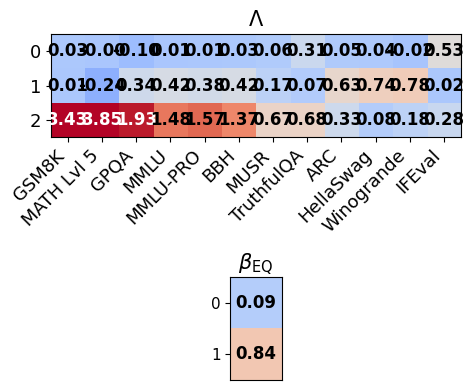

In [491]:
colormap = "coolwarm"
vmin=-1
vmax=2
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,4))
 # Set the figure size (width, height) in inches
#ax1.set_figwidth(6)
#ax1.set_figheight(3)
ax1.imshow(L_rot, cmap=colormap, vmin=vmin, vmax=vmax)
inter = [-.3,1.6]
for i in range(len(L_rot)):
    for j in range(len(L_rot.T)):
        value = L_rot[i, j]
        color = "black" if value > inter[0] and  value < inter[1] else "white"  # Conditional color
        text = ax1.text(j, i, f'{value:.2f}', size=12, ha="center", va="center", color=color, weight='bold')#
ax1.set_xticks(np.arange(len(Y_names)), labels=Y_names, rotation=45, ha="right")  # Set the x-tick labels
ax1.set_yticks(np.arange(d))
ax1.tick_params(labelsize=13) 
# Set the y-tick labels
ax1.set_title('$\\Lambda$', size=15)
#plt.subplot(1, 2, 2)  # Set the figure size (width, height) in inches
#ax2.set_figwidth(3)
#ax2.set_figheight(1)
ax2.imshow(B_ood[0:2], cmap=colormap, vmin=vmin, vmax=vmax)
inter = [-.3,1.6]
for i in range(len(B_ood[0:2])):
    for j in range(len(B_ood.T)):
        value = B_ood[i, j]
        color = "black" if value > inter[0] and  value < inter[1] else "white"  # Conditional color
        text = ax2.text(j, i, f'{value:.2f}', size=12, ha="center", va="center", color=color, weight='bold')#
ax2.set_xticks([],[])  # Set the x-tick labels
ax2.set_yticks(np.arange(2))  # Set the y-tick labels
ax2.tick_params(labelsize=11) 
ax2.set_title('$\\beta_{\\text{EQ}}$', size = 15)
plt.tight_layout()
plt.savefig('EQ_Parameters.pdf', bbox_inches='tight')
plt.show()

In [492]:
x, y = np.concatenate((X_tr, Inter_train), axis = 1) @ B_ood, Y_tr
x_test, y_test = np.concatenate((Z_hold, np.ones(1)[np.newaxis, :].T), axis = 1) @ B_ood, Y_hold
a, b, c, e = np.linspace(-5, 5, 100), np.linspace(-5, 5, 100), np.linspace(-5, 2, 100), np.linspace(-5, 2, 100)
Grid = np.vstack((a.flatten(), b.flatten(), c.flatten())).T
y_curve = model_ood.predict(Grid, np.array([[1]]))
x_grid = np.concatenate((Grid, np.ones(100)[np.newaxis, :].T), axis = 1) @ B_ood

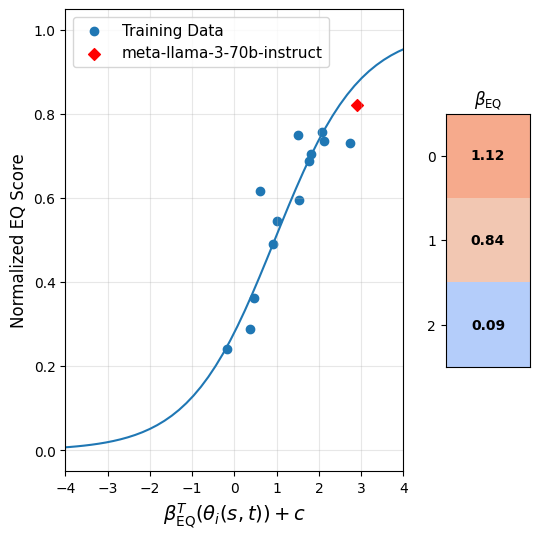

In [493]:
colormap = "coolwarm"
vmin=-1
vmax=2
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6,6), width_ratios=[4, 1])
 # Set the figure size (width, height) in inches
#ax1.set_figwidth(6)
#ax1.set_figheight(3)
ax2.imshow(B_ood[0:3][::-1], cmap=colormap, vmin=vmin, vmax=vmax)
inter = [-.3,1.6]
for i in range(len(B_ood[0:3][::-1])):
    for j in range(len(B_ood[0:3][::-1].T)):
        value = B_ood[0:3][::-1][i, j]
        color = "black" if value > inter[0] and  value < inter[1] else "white"  # Conditional color
        text = ax2.text(j, i, f'{value:.2f}', size=10, ha="center", va="center", color=color, weight='bold')#
ax2.set_xticks([], [])  # Set the x-tick labels
ax2.set_yticks(np.arange(d))  # Set the y-tick labels
ax2.set_title('$\\beta_{\\text{EQ}}$', size = 12)
#ax2.tick_params(labelsize=11)
ax1.scatter(x,y, label = 'Training Data')
ax1.scatter(x_test,y_test, color = 'red', label = 'meta-llama-3-70b-instruct', marker = 'D')
ax1.set_xlim(-4, 4)
#ax2.ylim(0,1)
ax1.set_xlabel('$\\beta_{\\text{EQ}}^T(\\theta_{i}(s,t)) +c$', size = 14)
ax1.grid(alpha = 0.3)
ax1.plot(x_grid, y_curve)
ax1.set_ylabel('Normalized EQ Score', size = 12)
#ax2.tick_params(labelsize=11)
ax1.legend(prop={'size':11})
plt.savefig('EQ_Plot.pdf', bbox_inches='tight')
plt.show()

# Creative Writing

In [81]:
data = pd.read_csv('data/data_v2.csv')
data['logS'] = np.log10(data['#Params (B)'])
data['logT'] = np.log10(data['Pretraining Data Size (T)'])
data['logSlogT'] = data['logS']*data['logT']
#data['logS2'] = data['logS']**2
#data['logT2'] = data['logT']**2
data['GreatFamily'] = data['Family']
data['Family'] = data['Family2']
X_names = ['logS','logT','logSlogT'] 
Y_names = ['GSM8K',
           'MATH Lvl 5',
           'GPQA',
           'MMLU',
           'MMLU-PRO',
           'BBH',
           'MUSR',
           'TruthfulQA',
           'ARC',
           'HellaSwag',
           'Winogrande',
           'IFEval']
S_base = ['MMLU', 'ARC', 'HellaSwag']
S_extra = ['GSM8K',
           'TruthfulQA',
           'Winogrande']
#Y_names = S_base+S_extra
CW_dat = {'meta-llama-3-70b-instruct': 71.77, 
           'meta-llama-3-8b-instruct': 62.41, 
          'yi-34b-chat': 71.54, 
          'qwen1.5-14b-chat': 66.38, 
           'gemma-7b-it': 48.25,
            'llama-2-13b-chat': 49.94, 'llama-2-7b-chat': 47.38, 'qwen1.5-4b-chat': 27.78, 'gemma-2b-it': 42.67, 'Qwen1.5-110B-Chat':76.02 }

In [82]:
holdout_names = ['meta-llama-3-70b-instruct', 'meta-llama-3-70b']
data_CW = data.loc[:,['Model','Family','GreatFamily','Instruct']+X_names+Y_names].dropna()
data_hold = data_CW.loc[data['Model'].isin(holdout_names)]
Models_dict = {k: v for v, k in enumerate(list(data_CW['Model']))}
to_drop = []
for model in holdout_names:
    to_drop.append(Models_dict[model])
to_drop.sort()

In [83]:
D_whole = np.array(pd.get_dummies(np.array(data_CW.Family))).astype(float)
D = np.delete(D_whole, to_drop, axis=0)
#D = np.ones(38)[np.newaxis, :].T
X_whole = np.array(data_CW.loc[:,X_names]).astype(float)
X = np.delete(X_whole, to_drop, axis=0)
Y_whole = np.array(data_CW.loc[:,Y_names]).astype(float)
Y = np.delete(Y_whole, to_drop, axis=0)
Cs = []
for s in Y_names:
    Cs.append(lower_bounds[s])
Cs = np.array(Cs).astype(float)[None,:]
Y.shape

(77, 12)

In [84]:
model = Sloth(d=3)
model.fit(X, D, Y, Cs, fit_C=False, train_link=False, positive_w=False, verbose=True)
model.best_loss

  0%|          | 0/100000 [00:00<?, ?it/s]

0.1 0.024269765242934227


  0%|          | 0/100000 [00:00<?, ?it/s]

0.01 0.02427876926958561


  0%|          | 0/100000 [00:00<?, ?it/s]

0.001 0.024296997115015984


0.024269765242934227

In [85]:
d= 3
if d==1:
    L_rot=-model.W2.numpy()
    B_rot=-np.vstack((model.W1_X.detach().numpy(), model.W1_D.detach().numpy()))
    Z = np.hstack((X,D))@B_rot
else:
    Z = model.interpret(anchor=0)['skills']
    L_rot = model.interpret(anchor=0)['loadings']
    B_rot = model.interpret(anchor=0)['B']
    Delta = model.interpret(anchor=0)['translation']

In [117]:
for name in holdout_names:
    data_CW = data_CW[data.Model != name]
Skills_dict = {k: v for v, k in enumerate(list(data_CW['Model']))}
to_keep = []
Y_tr = []
for model in list(CW_dat.keys()):
    if model != holdout_names[0]:
        try:
            to_keep.append(Skills_dict[model])
            Y_tr.append(CW_dat[model])
        except:
            print(model)
X_tr = Z[to_keep][:,2][np.newaxis, :].T
Inter_train  = np.ones(X_tr.shape[0])[np.newaxis, :].T
Y_tr = np.array(Y_tr).astype(float)
Y_tr = Y_tr[np.newaxis, :].T/100
Y_tr.shape

yi-34b-chat
Qwen1.5-110B-Chat


/tmp/ipykernel_51383/3492270833.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_CW = data_CW[data.Model != name]


(7, 1)

In [118]:
X_tr.shape

(7, 1)

In [119]:
D_hold = D_whole[to_drop[0]]
#D_hold = D[to_drop]
X_hold = X_whole[to_drop[0]]
Y_hold = np.array([CW_dat[holdout_names[0]]]).astype(float)
Y_hold = Y_hold[np.newaxis, :].T/100
Y_hold.shape

(1, 1)

In [120]:
model_ood = Sloth(d=1) 
model_ood.fit(X_tr, Inter_train, Y_tr,
                                      C0=np.array([[0]]),
                                      train_link=False, fit_C=False, positive_w=False, verbose=False)

In [121]:
Z_hold = np.hstack((X_hold,D_hold))@B_rot-Delta
B_ood=np.vstack((model_ood.W1_X.detach().numpy(), model_ood.W1_D.detach().numpy()))
B_ood

array([[ 1.2237449],
       [-0.1387904]], dtype=float32)

In [122]:
x, y = np.concatenate((X_tr, Inter_train), axis = 1) @ B_ood, Y_tr
x_test, y_test = np.concatenate((Z_hold[:,2][np.newaxis, :].T, np.ones(1)[np.newaxis, :].T), axis = 1) @ B_ood, Y_hold
a, b, c, e = np.linspace(-5, 5, 100), np.linspace(-5, 5, 100), np.linspace(-5, 2, 100), np.linspace(-5, 2, 100)
#Grid = np.vstack((a.flatten(), b.flatten(), c.flatten())).T
Grid = np.vstack((a.flatten()))
y_curve = model_ood.predict(Grid, np.array([[1]]))
x_grid = np.concatenate((Grid, np.ones(100)[np.newaxis, :].T), axis = 1) @ B_ood

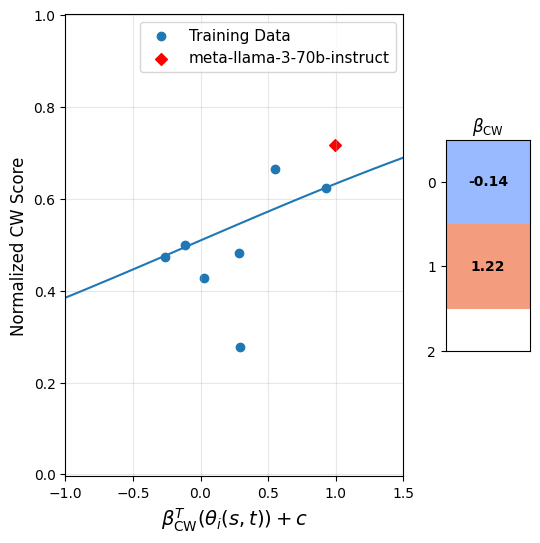

In [125]:
colormap = "coolwarm"
vmin=-1
vmax=2
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6,6), width_ratios=[4, 1])
 # Set the figure size (width, height) in inches
#ax1.set_figwidth(6)
#ax1.set_figheight(3)
ax2.imshow(B_ood[0:3][::-1], cmap=colormap, vmin=vmin, vmax=vmax)
inter = [-.3,1.6]
for i in range(len(B_ood[0:3][::-1])):
    for j in range(len(B_ood[0:3][::-1].T)):
        value = B_ood[0:3][::-1][i, j]
        color = "black" if value > inter[0] and  value < inter[1] else "white"  # Conditional color
        text = ax2.text(j, i, f'{value:.2f}', size=10, ha="center", va="center", color=color, weight='bold')#
ax2.set_xticks([], [])  # Set the x-tick labels
ax2.set_yticks(np.arange(d))  # Set the y-tick labels
ax2.set_title('$\\beta_{\\text{CW}}$', size = 12)
#ax2.tick_params(labelsize=11)
ax1.scatter(x,y, label = 'Training Data')
ax1.scatter(x_test,y_test, color = 'red', label = 'meta-llama-3-70b-instruct', marker = 'D')
ax1.set_xlim(-1, 1.5)
#ax2.ylim(0,1)
ax1.set_xlabel('$\\beta_{\\text{CW}}^T(\\theta_{i}(s,t)) +c$', size = 14)
ax1.grid(alpha = 0.3)
ax1.plot(x_grid, y_curve)
ax1.set_ylabel('Normalized CW Score', size = 12)
#ax2.tick_params(labelsize=11)
ax1.legend(prop={'size':11})
#plt.savefig('EQ_Plot.pdf', bbox_inches='tight')
plt.show()